In [9]:
import os, sys
import tarfile, glob
os.environ['R_HOME'] = sys.exec_prefix + '/lib/R/'
import numpy as np
import scanpy as sc
import scanpy.external as sce
import scFates as scf
import anndata as ad

In [ ]:
geo = 'GSE162534'
datadir = os.path.join('..', 'data', 'unzip', geo)
samples = sorted(os.listdir(datadir))
adata_dict = {key.replace('.tar.gz', '') : None for key in samples if 'velo' not in key}
for key in adata_dict:
    with tarfile.open(os.path.join(datadir, f'{key}.tar.gz'), 'r:gz') as tar:
        tar.extractall(path = os.path.join(datadir, key))
    key_fn = glob.glob(os.path.join(datadir, key, '*', '*', '*', '*'))[0]
    adata_dict[key] = sc.read_10x_mtx(key_fn)
adata = ad.concat(adata_dict, label = 'sample')
adata.obs_names_make_unique()

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
adata

AnnData object with n_obs × n_vars = 5898240 × 27998
    obs: 'sample'

In [12]:
sc.pp.filter_cells(adata, min_genes = 1000)

In [13]:
adata

AnnData object with n_obs × n_vars = 11366 × 27998
    obs: 'sample', 'n_genes'

In [14]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')

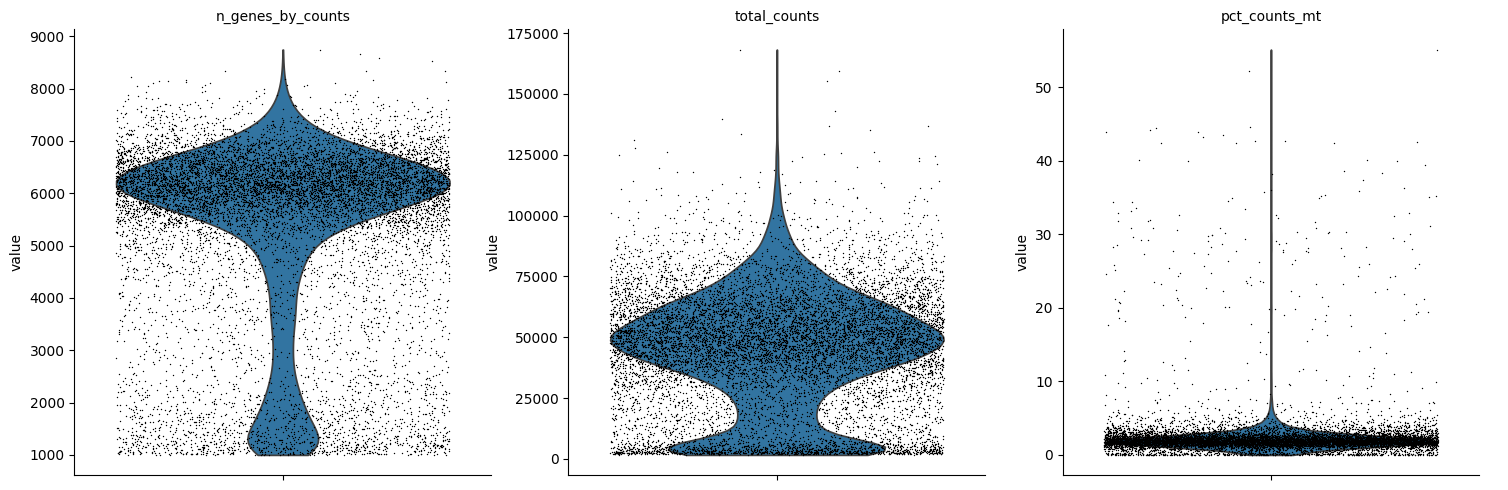

In [15]:
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top = None, inplace = True, log1p = False)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter = .4, multi_panel = True)

In [ ]:
adata = adata[
    (adata.obs.total_counts <= 125000) &
    (adata.obs.pct_counts_mt <= 8)
    ]

In [17]:
adata

View of AnnData object with n_obs × n_vars = 11122 × 27998
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [18]:
sc.pp.normalize_total(adata, target_sum = 50000)
sc.pp.log1p(adata)

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Finding overdispersed features
    computing mean and variances
    gam fitting
    found 3737 over-dispersed features (0:00:02) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



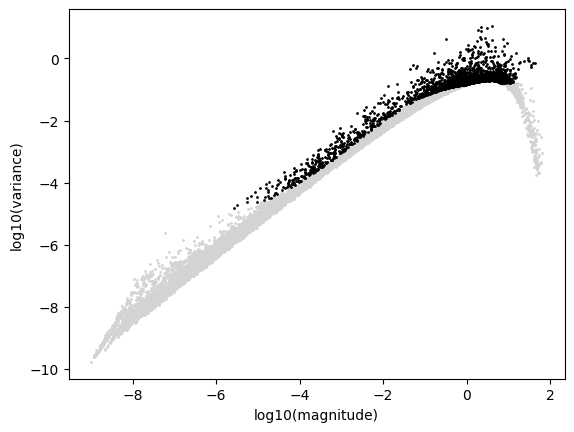

In [19]:
sc.pp.filter_genes(adata, min_cells = 3)
scf.pp.find_overdispersed(adata, plot = True)

In [20]:
sc.pp.pca(adata)
sce.pp.harmony_integrate(adata, 'sample')

2025-05-15 13:17:57,195 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-15 13:18:00,245 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-15 13:18:00,364 - harmonypy - INFO - Iteration 1 of 10
2025-05-15 13:18:05,820 - harmonypy - INFO - Iteration 2 of 10
2025-05-15 13:18:11,151 - harmonypy - INFO - Iteration 3 of 10
2025-05-15 13:18:16,772 - harmonypy - INFO - Converged after 3 iterations


In [21]:
sc.pp.neighbors(adata, n_pcs = 30, use_rep = 'X_pca_harmony')
sc.tl.umap(adata)
sc.tl.leiden(adata)

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_2820429/3027487967.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


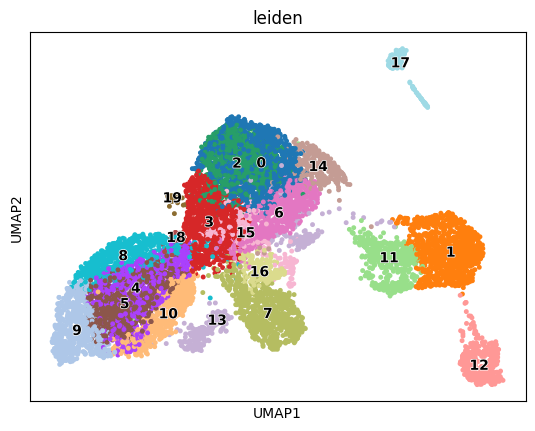

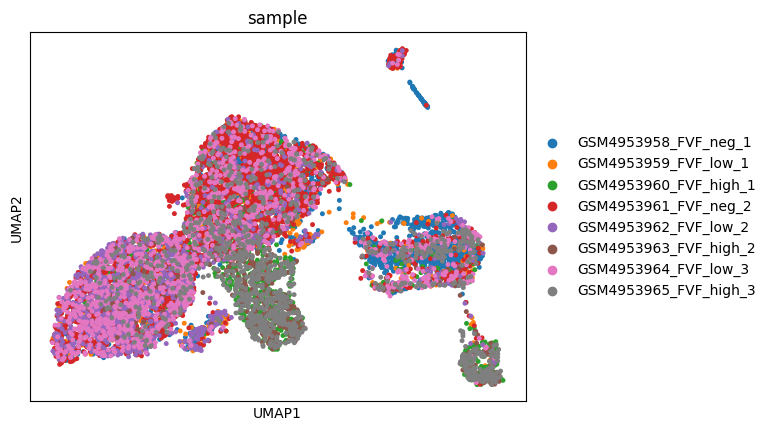

In [22]:
sc.pl.umap(adata, color = 'leiden', size = 50, legend_loc = 'on data', legend_fontoutline = True)
sc.pl.umap(adata, color = 'sample', size = 50)

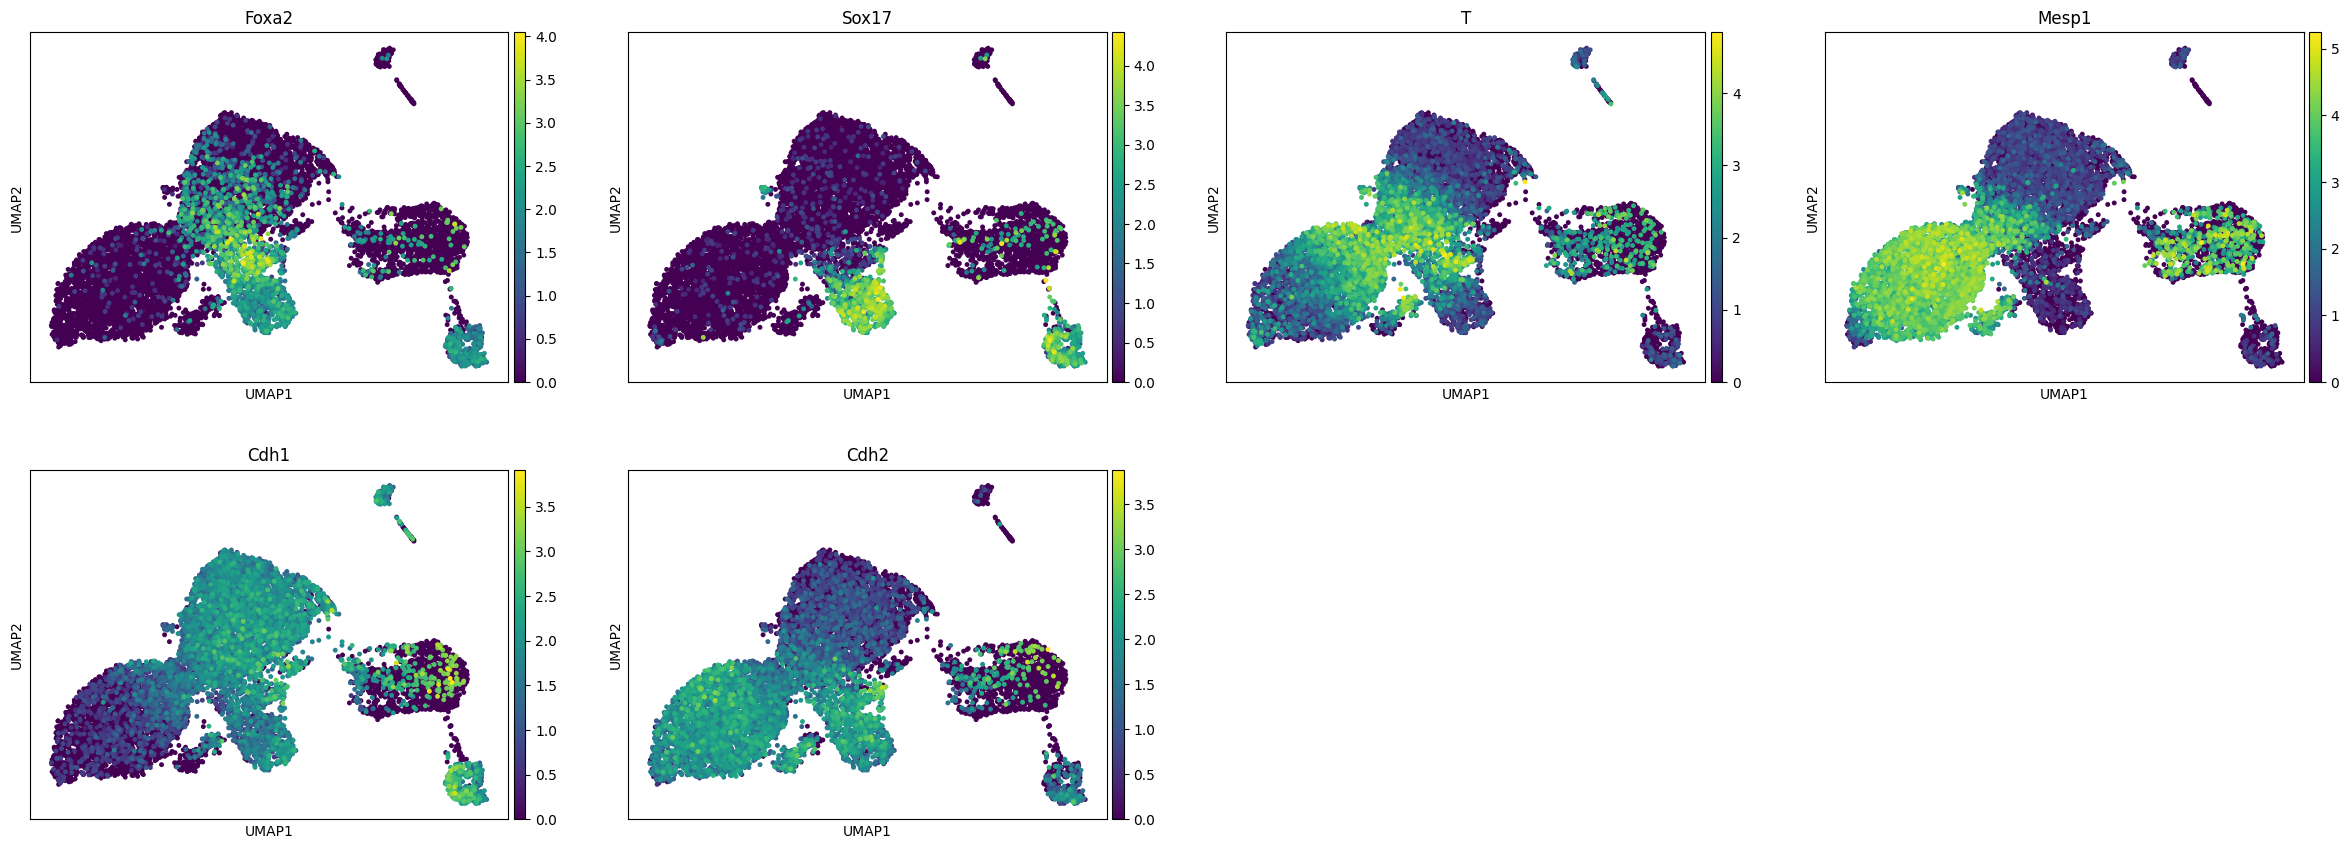

In [23]:
sc.pl.umap(adata, color = ['Foxa2', 'Sox17', 'T', 'Mesp1', 'Cdh1', 'Cdh2'], size = 50)

In [24]:
remove = np.array([17, 13, 1, 11, 12], dtype = str)
adata = adata[~adata.obs.leiden.isin(remove), :]

In [25]:
adata

View of AnnData object with n_obs × n_vars = 8725 × 19285
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'sample_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Finding overdispersed features
    computing mean and variances
    gam fitting
    found 3728 over-dispersed features (0:00:02) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



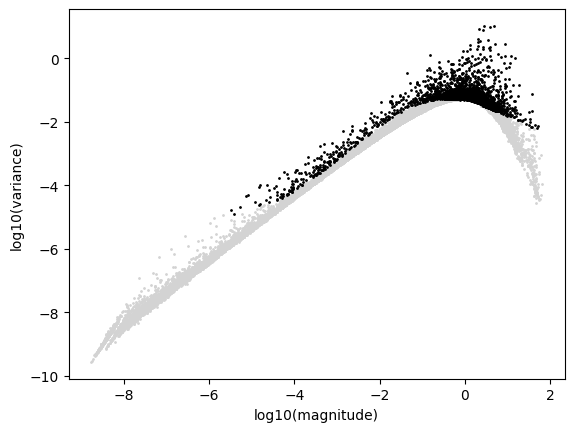

In [26]:
sc.pp.filter_genes(adata, min_cells = 3)
scf.pp.find_overdispersed(adata, plot = True)

In [27]:
sc.pp.pca(adata)
sce.pp.harmony_integrate(adata, 'sample')

2025-05-15 13:24:59,228 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-15 13:25:01,961 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-15 13:25:02,064 - harmonypy - INFO - Iteration 1 of 10
2025-05-15 13:25:06,287 - harmonypy - INFO - Iteration 2 of 10
2025-05-15 13:25:09,825 - harmonypy - INFO - Iteration 3 of 10
2025-05-15 13:25:13,245 - harmonypy - INFO - Iteration 4 of 10
2025-05-15 13:25:16,560 - harmonypy - INFO - Converged after 4 iterations


In [31]:
sc.pp.neighbors(adata, n_pcs = 30, use_rep = 'X_pca_harmony')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = .2)

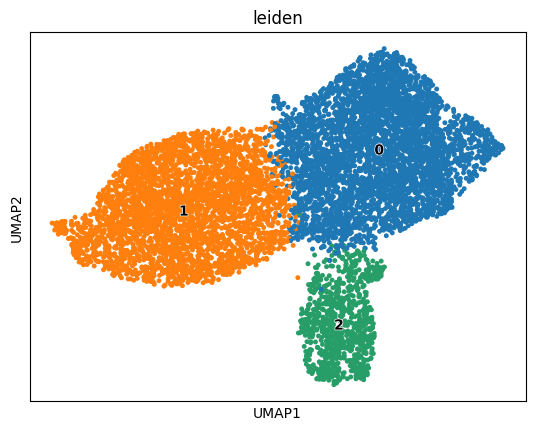

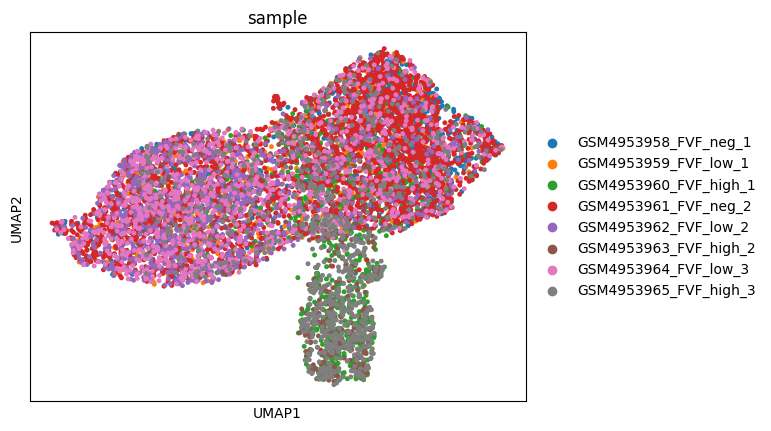

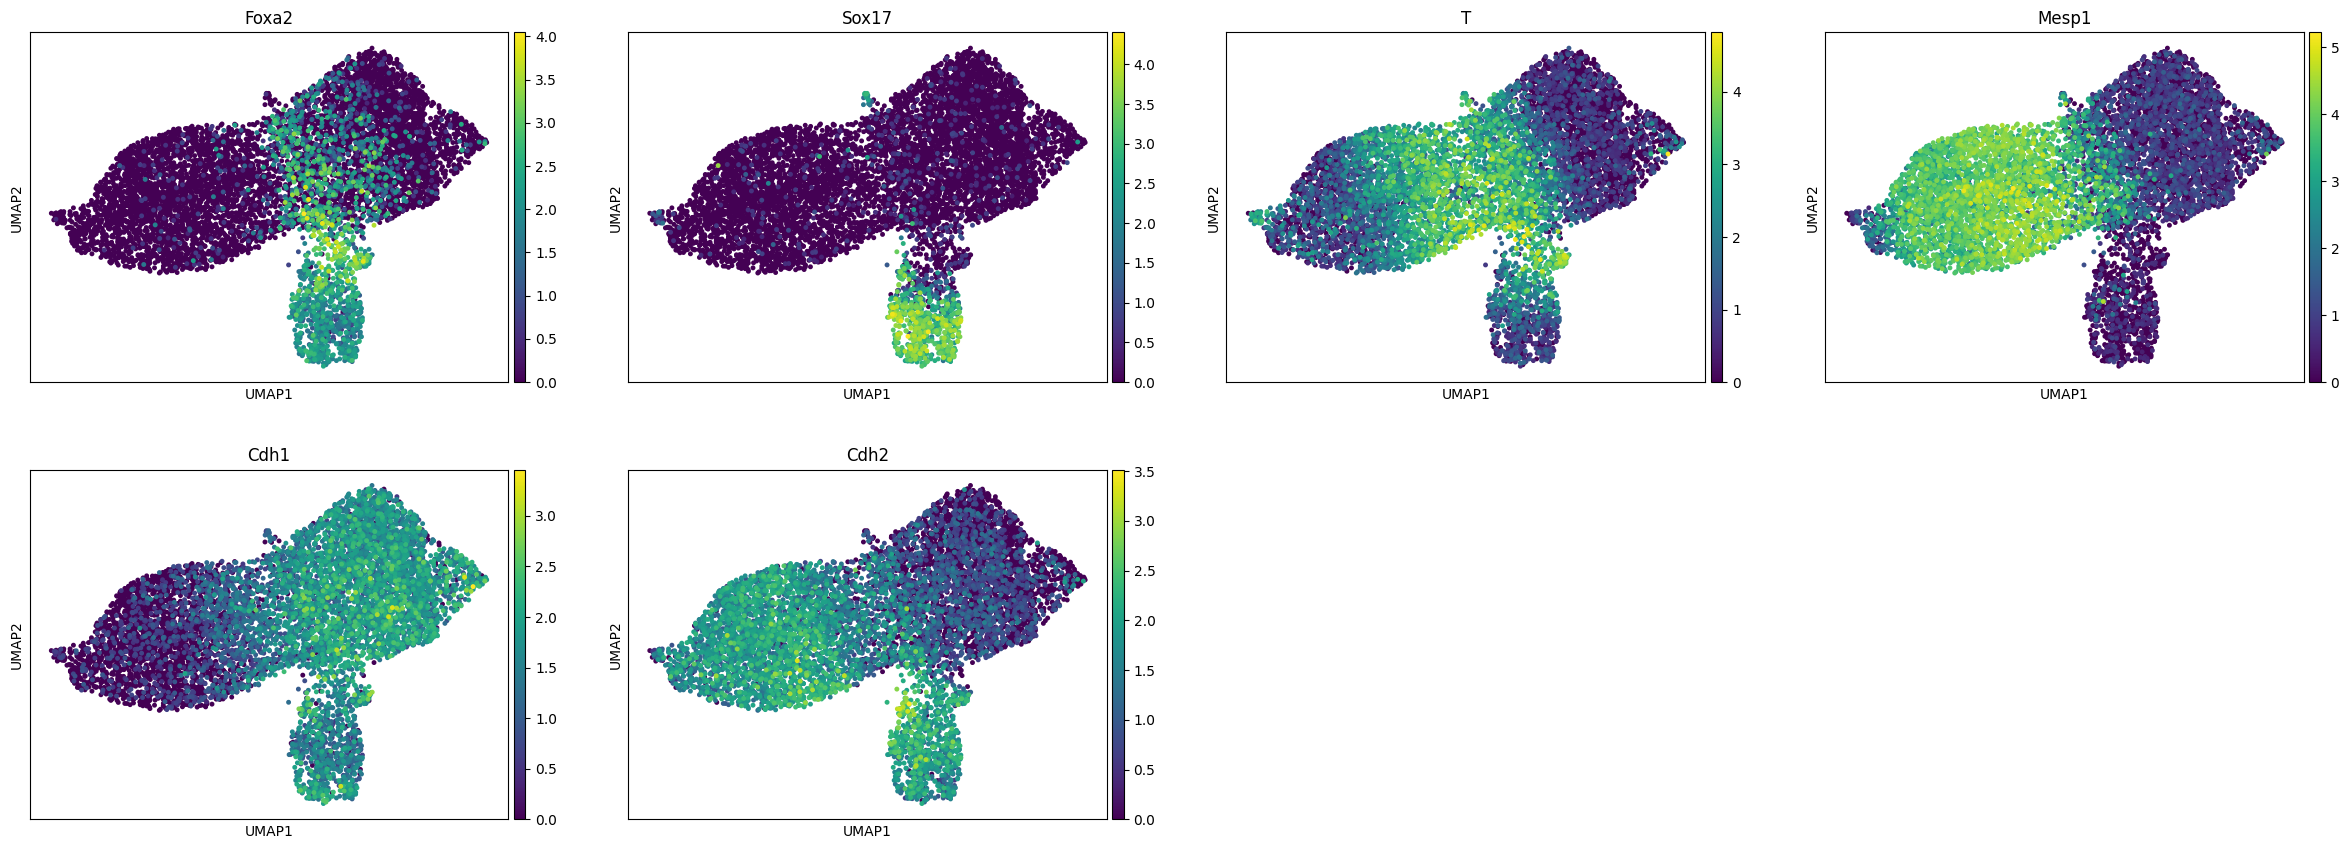

In [32]:
sc.pl.umap(adata, color = 'leiden', size = 50, legend_loc = 'on data', legend_fontoutline = True)
sc.pl.umap(adata, color = 'sample', size = 50)
sc.pl.umap(adata, color = ['Foxa2', 'Sox17', 'T', 'Mesp1', 'Cdh1', 'Cdh2'], size = 50)

In [33]:
celltype_dict = {
    '0' : 'Posterior Epiblast',
    '1' : 'Lateral Plate Mesoderm',
    '2' : 'Definitive Endoderm'
    }
adata.obs['celltype'] = adata.obs.leiden.map(celltype_dict).astype('category')

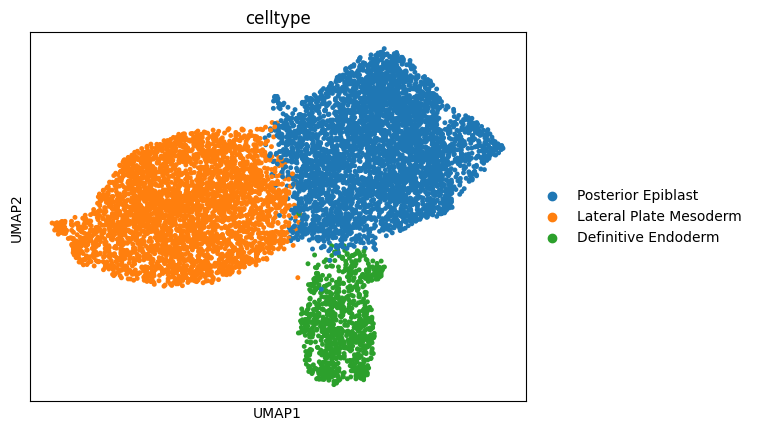

In [34]:
sc.pl.umap(adata, color = 'celltype', size = 50)

In [ ]:
outdir = os.path.join('..', 'data', 'processed', geo)
os.mkdir(outdir)
adata.write(os.path.join(outdir, f'{geo}_adata_processed.h5ad'))